In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ***Extract ZIP File from Google Drive to ACDC Dataset Folder***

In [ ]:
# Define paths
import zipfile
zip_path = "/content/drive/MyDrive/database.zip"  # Ensure correct path
extract_path = "/content/drive/MyDrive/ACDC dataset"  # Updated path name

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f" Extracted successfully to: {extract_path}")


 Extracted successfully to: /content/drive/MyDrive/ACDC dataset


# ***Visual Inspection of Cardiac MRI and Segmentation Overlay***

In [ ]:
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 24.3 MB/s eta 0:00:00


 Selected: patient061 — patient061_frame10
 Image shape: (9, 256, 216), Label shape: (9, 256, 216)
 Unique label values: [0 1 2 3]


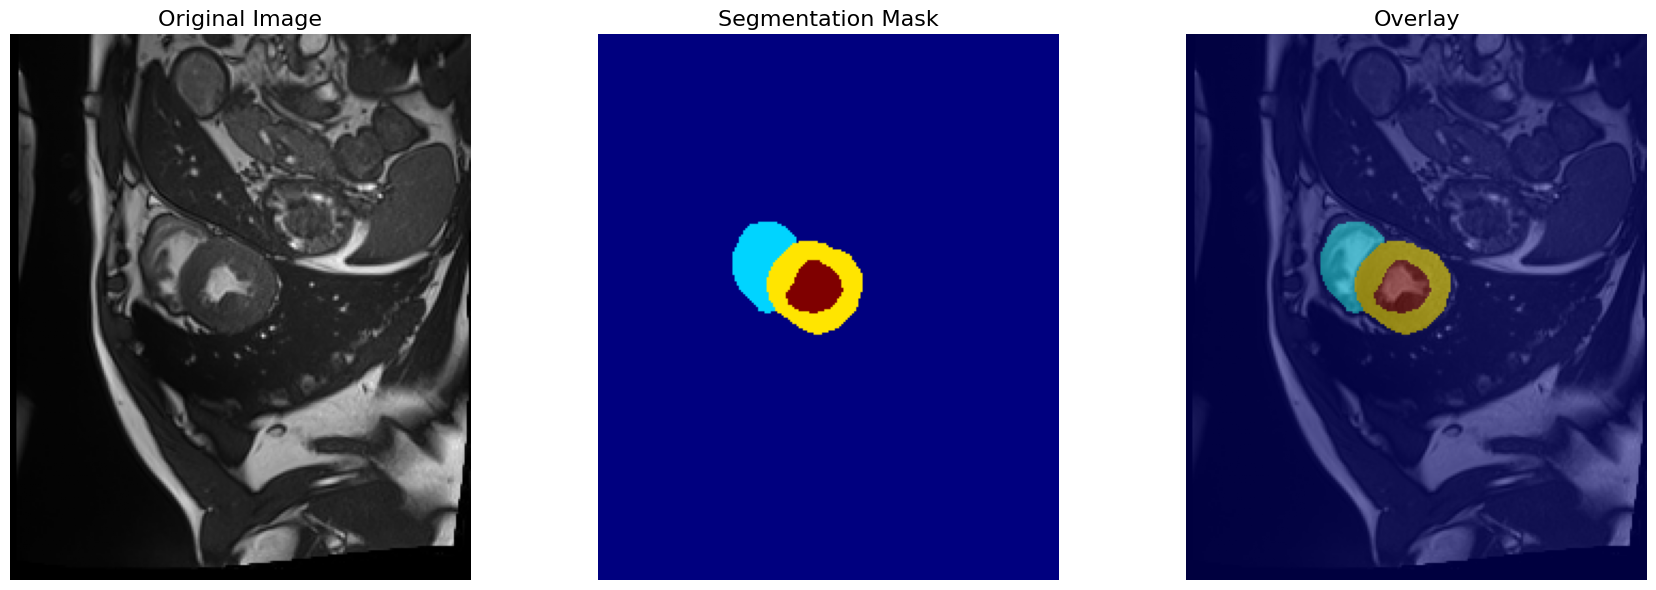

In [ ]:
import os
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import random

# --- Define the base data directory ---
data_dir = "/content/drive/MyDrive/ACDC dataset/database/training"

# --- Randomly select a patient and frame ---
patient_list = sorted([p for p in os.listdir(data_dir) if p.startswith("patient")])
patient_id = random.choice(patient_list)
patient_path = os.path.join(data_dir, patient_id)

# Select random frame (excluding 4d and ground truth files)
frame_files = sorted([f for f in os.listdir(patient_path) if f.endswith(".nii.gz") and "_gt" not in f and "4d" not in f])
frame_file = random.choice(frame_files)
frame_id = frame_file.replace(".nii.gz", "")

# --- Paths ---
image_path = os.path.join(patient_path, f"{frame_id}.nii.gz")
label_path = os.path.join(patient_path, f"{frame_id}_gt.nii.gz")

# --- Load functions ---
def load_nifti(file_path, data_type=sitk.sitkFloat32):
    return sitk.GetArrayFromImage(sitk.ReadImage(file_path, data_type))

# --- Load image and label ---
image = load_nifti(image_path)
label = load_nifti(label_path, sitk.sitkInt32)

# --- Info ---
print(f" Selected: {patient_id} — {frame_id}")
print(f" Image shape: {image.shape}, Label shape: {label.shape}")
print(f" Unique label values: {np.unique(label)}")

# --- Mid slice ---
mid_slice = image.shape[0] // 2
image_slice = image[mid_slice, :, :]
label_slice = label[mid_slice, :, :]

# --- Plot ---
fig, axarr = plt.subplots(1, 3, figsize=(18, 6))

titles = ["Original Image", "Segmentation Mask", "Overlay"]
images = [image_slice, label_slice, (image_slice, label_slice)]
cmaps = ["gray", "jet", None]

for i in range(3):
    if i < 2:
        axarr[i].imshow(images[i], cmap=cmaps[i], origin='lower')
    else:
        axarr[i].imshow(images[2][0], cmap="gray", origin='lower')
        axarr[i].imshow(images[2][1], cmap="jet", alpha=0.5, origin='lower')
    axarr[i].set_title(titles[i], fontsize=16)
    axarr[i].set_xlabel(f"{patient_id} — {frame_id}", fontsize=12)
    axarr[i].axis('off')

plt.tight_layout()
plt.show()


# ***Split ACDC Dataset into Training/Testing with Images and Labels***

In [ ]:
import os
import shutil

# Define root path
base_data_dir = "/content/drive/MyDrive/ACDC dataset/database"

# Subsets: training and testing
for subset in ["training", "testing"]:
    subset_path = os.path.join(base_data_dir, subset)

    # Create Images and Labels folders inside each subset
    images_dir = os.path.join(subset_path, "Images")
    labels_dir = os.path.join(subset_path, "Labels")
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    # Iterate through each patient folder
    for patient in sorted(os.listdir(subset_path)):
        patient_path = os.path.join(subset_path, patient)

        # Skip non-folder items (like .md files or already-created folders)
        if not os.path.isdir(patient_path) or patient in ["Images", "Labels"]:
            continue

        for file in sorted(os.listdir(patient_path)):
            file_path = os.path.join(patient_path, file)

            # Skip 4D files
            if "4d.nii.gz" in file:
                continue

            # Copy to appropriate folder
            if "_gt.nii.gz" in file:
                shutil.copy(file_path, os.path.join(labels_dir, file))
            else:
                shutil.copy(file_path, os.path.join(images_dir, file))

print(" Data sorted: training/testing → Images & Labels separated.")


 Data sorted: training/testing → Images & Labels separated.


# ***Comparison of Intensity Normalization Techniques on a 3D Medical Image Slice***

Comparison of different normalization methods is ready.


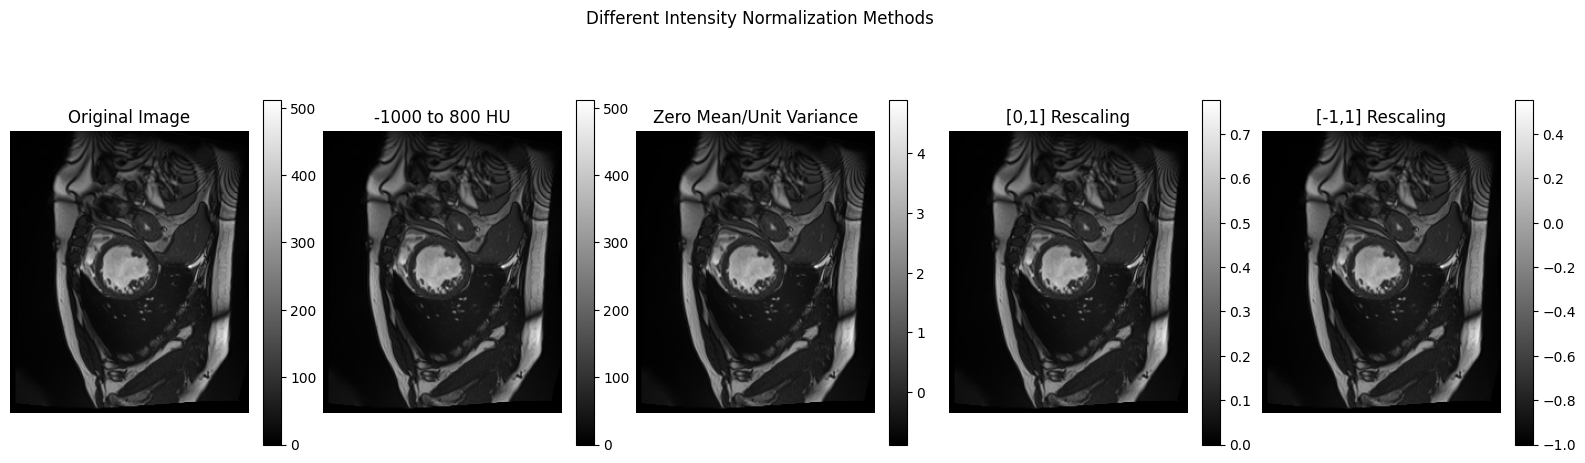

In [ ]:
import os
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

# --- Define normalization functions ---
def normalise(image):
    np_img = np.clip(image, -1000., 800.).astype(np.float32)
    return np_img

def whitening(image):
    image = image.astype(np.float32)
    mean, std = np.mean(image), np.std(image)
    return (image - mean) / std if std > 0 else image * 0.

def normalise_zero_one(image):
    image = image.astype(np.float32)
    minimum, maximum = np.min(image), np.max(image)
    return (image - minimum) / (maximum - minimum) if maximum > minimum else image * 0.

def normalise_one_one(image):
    ret = normalise_zero_one(image)
    return ret * 2. - 1.

# --- Define path ---
data_dir = "/content/drive/MyDrive/ACDC dataset/database/training/Images"

# Get list of available files
files = [f for f in os.listdir(data_dir) if f.endswith(".nii.gz")]
if not files:
    print("Error: No NIfTI files found in the directory!")
else:
    # Select a sample image for visualization
    sample_patient = files[0]
    sample_image_path = os.path.join(data_dir, sample_patient)

    # Load image using SimpleITK
    img_sitk = sitk.ReadImage(sample_image_path, sitk.sitkFloat32)
    image = sitk.GetArrayFromImage(img_sitk)

    # --- Apply normalization techniques ---
    hu_norm = normalise(image)
    zero_mean_norm = whitening(image)
    zero_one_norm = normalise_zero_one(image)
    minus_one_one_norm = normalise_one_one(image)

    print("Comparison of different normalization methods is ready.")

    # --- Select middle slice ---
    mid_slice = image.shape[0] // 2

    # --- Plot results ---
    fig, axarr = plt.subplots(1, 5, figsize=(20, 5))
    fig.suptitle('Different Intensity Normalization Methods')
    methods = [
        (image, 'Original Image'),
        (hu_norm, '-1000 to 800 HU'),
        (zero_mean_norm, 'Zero Mean/Unit Variance'),
        (zero_one_norm, '[0,1] Rescaling'),
        (minus_one_one_norm, '[-1,1] Rescaling')
    ]
    for i, (img, title) in enumerate(methods):
        img_plot = axarr[i].imshow(np.squeeze(img[mid_slice, :, :]), cmap='gray', origin='lower')
        axarr[i].axis('off')
        axarr[i].set_title(title)
        fig.colorbar(img_plot, ax=axarr[i])

    fig.subplots_adjust(wspace=0.05, hspace=0, top=0.8)
    plt.show()


# ***Preprocessing Both Training and Testing Data***

In [ ]:
import os
import shutil
import numpy as np
import SimpleITK as sitk
import nibabel as nib

# Define base directory for the ACDC dataset
base_dir = "/content/drive/MyDrive/ACDC dataset"

# Define paths for training and testing data
datasets = {
    "training": {
        "raw_dir": os.path.join(base_dir, "database/training"),
        "image_dir": os.path.join(base_dir, "training/Images"),
        "label_dir": os.path.join(base_dir, "training/Labels"),
        "prep_image_dir": os.path.join(base_dir, "training/Normalized_Resampled_Images"),
        "prep_label_dir": os.path.join(base_dir, "training/Resampled_Labels"),
    },
    "testing": {
        "raw_dir": os.path.join(base_dir, "database/testing"),
        "image_dir": os.path.join(base_dir, "testing/Images"),
        "label_dir": os.path.join(base_dir, "testing/Labels"),
        "prep_image_dir": os.path.join(base_dir, "testing/Normalized_Resampled_Images"),
        "prep_label_dir": os.path.join(base_dir, "testing/Resampled_Labels"),
    },
}

# Create required directories for both training and testing
for phase, paths in datasets.items():
    os.makedirs(paths["image_dir"], exist_ok=True)
    os.makedirs(paths["label_dir"], exist_ok=True)
    os.makedirs(paths["prep_image_dir"], exist_ok=True)
    os.makedirs(paths["prep_label_dir"], exist_ok=True)

# Extract original images and labels from raw folders for each phase
for phase, paths in datasets.items():
    for patient in sorted(os.listdir(paths["raw_dir"])):
        patient_path = os.path.join(paths["raw_dir"], patient)
        if not os.path.isdir(patient_path):
            continue
        for file in sorted(os.listdir(patient_path)):
            if "4d.nii.gz" in file:
                continue
            src = os.path.join(patient_path, file)
            if "_gt.nii.gz" in file:
                shutil.copy(src, os.path.join(paths["label_dir"], file))
            else:
                shutil.copy(src, os.path.join(paths["image_dir"], file))
    print(f"{phase.capitalize()} original images and labels copied successfully.")

# Normalize image by zero-mean and unit-variance
def whitening(image):
    image = image.astype(np.float32)
    mean = np.mean(image)
    std = np.std(image)
    return (image - mean) / std if std > 0 else np.zeros_like(image)

# Resample image to a new spacing
def resample_img(itk_image, out_spacing=[1.0, 1.0, 1.0], is_label=False):
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()
    out_size = [int(np.round(original_size[i] * (original_spacing[i] / out_spacing[i])))
                for i in range(3)]
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
    resample.SetInterpolator(sitk.sitkNearestNeighbor if is_label else sitk.sitkBSpline)
    return resample.Execute(itk_image)

# Get bounding box from label projection (in-plane only)
def get_inplane_bounding_box(mask_array):
    projection = np.max(mask_array, axis=0)
    coords = np.where(projection > 0)
    if coords[0].size == 0:
        return (0, mask_array.shape[1], 0, mask_array.shape[2])
    min_y = np.min(coords[0])
    max_y = np.max(coords[0])
    min_x = np.min(coords[1])
    max_x = np.max(coords[1])
    return (min_y, max_y + 1, min_x, max_x + 1)

# Resample image to target size
def resample_to_target(itk_image, target_size, is_label=False):
    target_size_sitk = (target_size[2], target_size[1], target_size[0])
    original_size = itk_image.GetSize()
    original_spacing = itk_image.GetSpacing()
    new_spacing = [original_spacing[i] * (original_size[i] / target_size_sitk[i])
                   for i in range(3)]
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(new_spacing)
    resample.SetSize(target_size_sitk)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
    resample.SetInterpolator(sitk.sitkNearestNeighbor if is_label else sitk.sitkBSpline)
    return resample.Execute(itk_image)

# Preprocess and save all images for each phase
for phase, paths in datasets.items():
    for file_name in sorted(os.listdir(paths["image_dir"])):
        if not file_name.endswith(".nii.gz"):
            continue

        img_path = os.path.join(paths["image_dir"], file_name)
        label_path = os.path.join(paths["label_dir"], file_name.replace(".nii.gz", "_gt.nii.gz"))
        if not os.path.exists(label_path):
            print(f"Skipping {file_name} (label not found)")
            continue

        img_sitk = sitk.ReadImage(img_path, sitk.sitkFloat32)
        label_sitk = sitk.ReadImage(label_path, sitk.sitkUInt8)

        img_resampled = resample_img(img_sitk, [1.0, 1.0, 1.0], is_label=False)
        label_resampled = resample_img(label_sitk, [1.0, 1.0, 1.0], is_label=True)

        img_array = sitk.GetArrayFromImage(img_resampled)
        label_array = sitk.GetArrayFromImage(label_resampled)

        min_y, max_y, min_x, max_x = get_inplane_bounding_box(label_array)
        img_cropped = img_array[:, min_y:max_y, min_x:max_x]
        label_cropped = label_array[:, min_y:max_y, min_x:max_x]

        img_cropped_sitk = sitk.GetImageFromArray(img_cropped)
        img_cropped_sitk.CopyInformation(img_resampled)
        label_cropped_sitk = sitk.GetImageFromArray(label_cropped)
        label_cropped_sitk.CopyInformation(label_resampled)

        # Set new fixed depth to 96 instead of 100
        target_size_final = (96, 128, 128)

        final_img_sitk = resample_to_target(img_cropped_sitk, target_size_final, is_label=False)
        final_label_sitk = resample_to_target(label_cropped_sitk, target_size_final, is_label=True)

        final_img_array = sitk.GetArrayFromImage(final_img_sitk)
        normalized_array = whitening(final_img_array)

        nib.save(nib.Nifti1Image(normalized_array, np.eye(4)),
                 os.path.join(paths["prep_image_dir"], file_name))
        nib.save(nib.Nifti1Image(sitk.GetArrayFromImage(final_label_sitk), np.eye(4)),
                 os.path.join(paths["prep_label_dir"], file_name.replace(".nii.gz", "_gt.nii.gz")))

        print(f"Processed {phase}: {file_name}")

print("\nAll training and testing images have been preprocessed and saved successfully.")


Training original images and labels copied successfully.
Testing original images and labels copied successfully.
Processed training: patient001_frame01.nii.gz
Processed training: patient001_frame12.nii.gz
Processed training: patient002_frame01.nii.gz
Processed training: patient002_frame12.nii.gz
Processed training: patient003_frame01.nii.gz
Processed training: patient003_frame15.nii.gz
Processed training: patient004_frame01.nii.gz
Processed training: patient004_frame15.nii.gz
Processed training: patient005_frame01.nii.gz
Processed training: patient005_frame13.nii.gz
Processed training: patient006_frame01.nii.gz
Processed training: patient006_frame16.nii.gz
Processed training: patient007_frame01.nii.gz
Processed training: patient007_frame07.nii.gz
Processed training: patient008_frame01.nii.gz
Processed training: patient008_frame13.nii.gz
Processed training: patient009_frame01.nii.gz
Processed training: patient009_frame13.nii.gz
Processed training: patient010_frame01.nii.gz
Processed tra

# ***Visual Quality Check of Preprocessed CT and Segmentation Masks***

Original  Shape: (180, 224, 10), Processed  Shape: (96, 128, 128), Mask Shape: (96, 128, 128)
Displaying: patient093_frame01.nii.gz


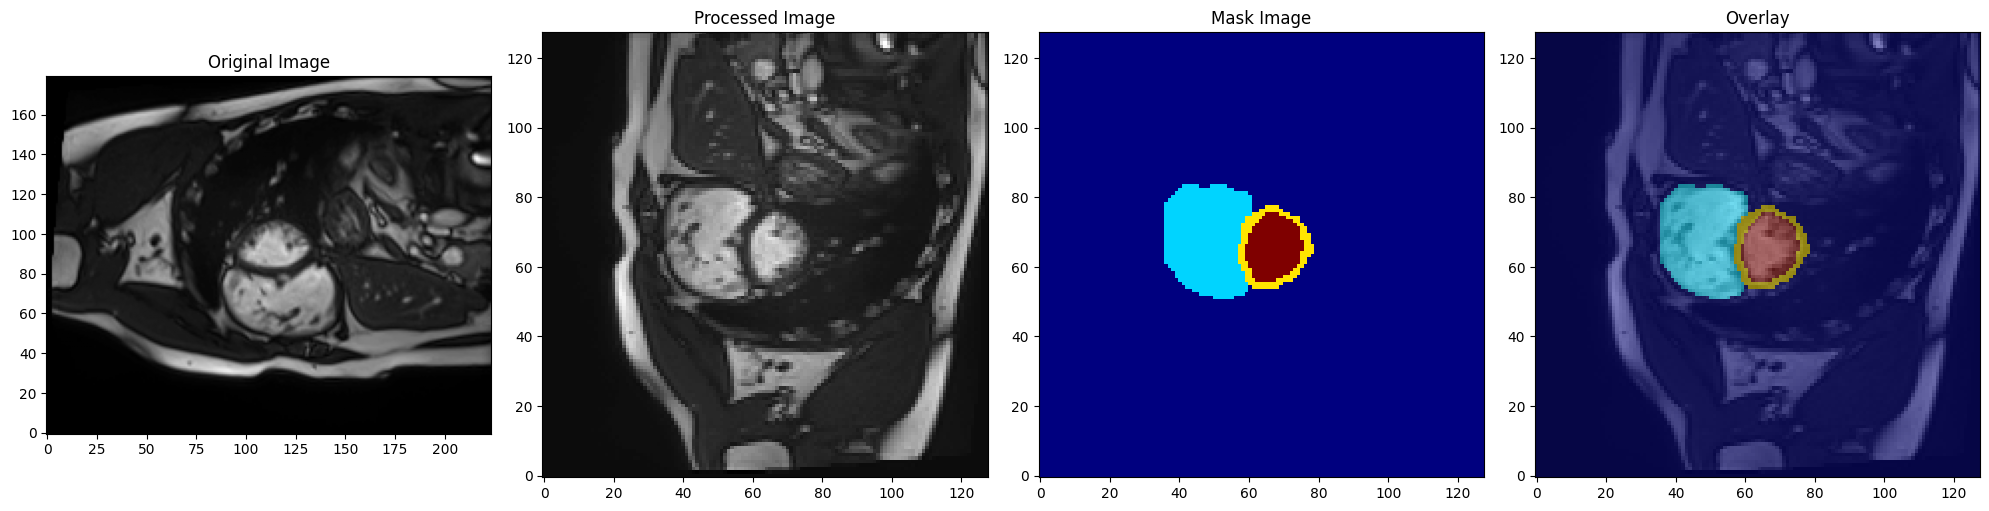

In [ ]:
import os
import random
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# Paths for training images/masks
base_dir = "/content/drive/MyDrive/ACDC dataset/training"
original_ct_dir = os.path.join(base_dir, "Images")
processed_ct_dir = os.path.join(base_dir, "Normalized_Resampled_Images")
processed_mask_dir = os.path.join(base_dir, "Resampled_Labels")

# Get a list of processed CT files
ct_files = [f for f in os.listdir(processed_ct_dir) if f.endswith(".nii.gz")]

if not ct_files:
    print("No available files in the directory.")
else:
    sample_patient = random.choice(ct_files)

    original_ct_path = os.path.join(original_ct_dir, sample_patient)
    processed_ct_path = os.path.join(processed_ct_dir, sample_patient)
    processed_mask_path = os.path.join(processed_mask_dir, sample_patient.replace(".nii.gz", "_gt.nii.gz"))

    if not os.path.exists(processed_mask_path) or not os.path.exists(original_ct_path):
        print(f"Missing files for: {sample_patient}, skipping.")
    else:
        original_ct_image = nib.load(original_ct_path).get_fdata()
        processed_ct_image = nib.load(processed_ct_path).get_fdata()
        mask_image = nib.load(processed_mask_path).get_fdata()

        print(f"Original  Shape: {original_ct_image.shape}, Processed  Shape: {processed_ct_image.shape}, Mask Shape: {mask_image.shape}")
        print(f"Displaying: {sample_patient}")

        mid_slice_original = original_ct_image.shape[2] // 2
        mid_slice_processed = processed_ct_image.shape[0] // 2

        fig, axarr = plt.subplots(1, 4, figsize=(20, 5))
        axarr[0].imshow(np.squeeze(original_ct_image[:, :, mid_slice_original]), cmap='gray', origin='lower')
        axarr[0].set_title("Original Image")

        axarr[1].imshow(np.squeeze(processed_ct_image[mid_slice_processed, :, :]), cmap='gray', origin='lower')
        axarr[1].set_title("Processed Image")

        axarr[2].imshow(np.squeeze(mask_image[mid_slice_processed, :, :]), cmap='jet', origin='lower')
        axarr[2].set_title("Mask Image")

        axarr[3].imshow(np.squeeze(processed_ct_image[mid_slice_processed, :, :]), cmap='gray', alpha=1, origin='lower')
        axarr[3].imshow(np.squeeze(mask_image[mid_slice_processed, :, :]), cmap='jet', alpha=0.5, origin='lower')
        axarr[3].set_title("Overlay")

        plt.tight_layout()
        plt.show()


# ***Augmenting 3D Training Data with Flip, Affine, and Noise***

In [ ]:
!pip install torchio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu

In [ ]:
import os
import torchio as tio

# Define input/output folders
image_dir = "/content/drive/MyDrive/ACDC dataset/training/Normalized_Resampled_Images"
label_dir = "/content/drive/MyDrive/ACDC dataset/training/Resampled_Labels"
aug_image_dir = "/content/drive/MyDrive/ACDC dataset/training/Augmented_Images"
aug_label_dir = "/content/drive/MyDrive/ACDC dataset/training/Augmented_Labels"

os.makedirs(aug_image_dir, exist_ok=True)
os.makedirs(aug_label_dir, exist_ok=True)

# Define augmentation pipeline
transform = tio.Compose([
    tio.RandomFlip(axes=('LR',), p=0.5),
    tio.RandomAffine(scales=(0.9, 1.1), degrees=10, translation=5, p=0.7),
    tio.RandomNoise(mean=0, std=0.01, p=0.3),
])

# Loop over each image
for filename in os.listdir(image_dir):
    if not filename.endswith('.nii.gz'):
        continue

    image_path = os.path.join(image_dir, filename)
    label_path = os.path.join(label_dir, filename.replace(".nii.gz", "_gt.nii.gz"))

    if not os.path.exists(label_path):
        print(f"Missing label for: {filename}")
        continue

    subject = tio.Subject(
        image=tio.ScalarImage(image_path),
        label=tio.LabelMap(label_path)
    )

    for i in range(10):
        transformed = transform(subject)

        aug_img_name = filename.replace(".nii.gz", f"_aug{i+1}.nii.gz")
        aug_label_name = filename.replace(".nii.gz", f"_aug{i+1}_gt.nii.gz")

        transformed['image'].save(os.path.join(aug_image_dir, aug_img_name))
        transformed['label'].save(os.path.join(aug_label_dir, aug_label_name))

        print(f"Augmented version {i+1}/10 saved for: {filename}")


Augmented version 1/10 saved for: patient001_frame01.nii.gz
Augmented version 2/10 saved for: patient001_frame01.nii.gz
Augmented version 3/10 saved for: patient001_frame01.nii.gz
Augmented version 4/10 saved for: patient001_frame01.nii.gz
Augmented version 5/10 saved for: patient001_frame01.nii.gz
Augmented version 6/10 saved for: patient001_frame01.nii.gz
Augmented version 7/10 saved for: patient001_frame01.nii.gz
Augmented version 8/10 saved for: patient001_frame01.nii.gz
Augmented version 9/10 saved for: patient001_frame01.nii.gz
Augmented version 10/10 saved for: patient001_frame01.nii.gz
Augmented version 1/10 saved for: patient001_frame12.nii.gz
Augmented version 2/10 saved for: patient001_frame12.nii.gz
Augmented version 3/10 saved for: patient001_frame12.nii.gz
Augmented version 4/10 saved for: patient001_frame12.nii.gz
Augmented version 5/10 saved for: patient001_frame12.nii.gz
Augmented version 6/10 saved for: patient001_frame12.nii.gz
Augmented version 7/10 saved for: patie

In [ ]:
aug_image_dir = "/content/drive/MyDrive/ACDC dataset/training/Augmented_Images"
aug_label_dir = "/content/drive/MyDrive/ACDC dataset/training/Augmented_Labels"

print("Augmented Images:", len(os.listdir(aug_image_dir)))
print("Augmented Labels:", len(os.listdir(aug_label_dir)))


Augmented Images: 2000
Augmented Labels: 2000


# ***Visualization of Augmentation Results and Mask Alignment***

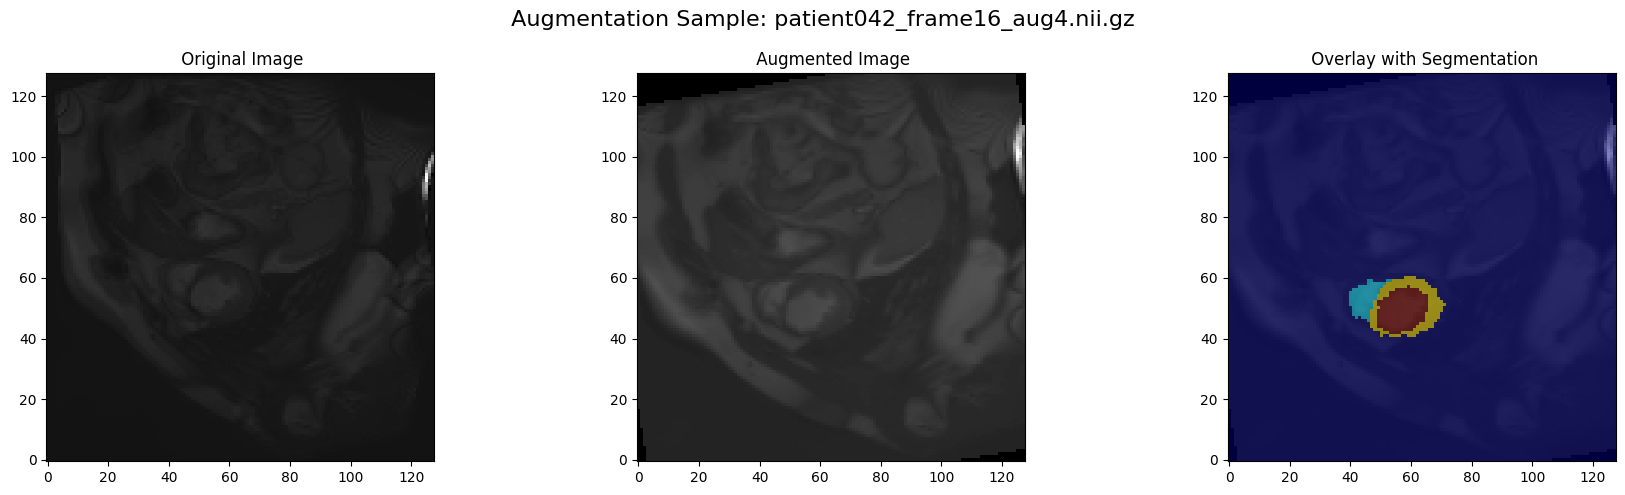

In [ ]:
# Define directories
original_dir = "/content/drive/MyDrive/ACDC dataset/training/Normalized_Resampled_Images"
augmented_dir = "/content/drive/MyDrive/ACDC dataset/training/Augmented_Images"
aug_label_dir = "/content/drive/MyDrive/ACDC dataset/training/Augmented_Labels"


# Select a random original image (base filename)
original_files = [f for f in os.listdir(original_dir) if f.endswith(".nii.gz")]
sample_base = random.choice(original_files).replace(".nii.gz", "")

# Find all augmented versions for that base image
aug_files = [f for f in os.listdir(augmented_dir) if sample_base in f]
aug_sample = random.choice(aug_files)

# Load original, augmented image, and corresponding augmented label
original_image = nib.load(os.path.join(original_dir, sample_base + ".nii.gz")).get_fdata()
augmented_image = nib.load(os.path.join(augmented_dir, aug_sample)).get_fdata()
augmented_label = nib.load(os.path.join(aug_label_dir, aug_sample.replace(".nii.gz", "_gt.nii.gz"))).get_fdata()

# Select the middle slice along the depth axis
slice_idx = augmented_image.shape[0] // 2

# Plot original image, augmented image, and overlay
fig, axarr = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(f" Augmentation Sample: {aug_sample}", fontsize=16)

axarr[0].imshow(np.squeeze(original_image[slice_idx, :, :]), cmap='gray', origin='lower')
axarr[0].set_title(" Original Image")

axarr[1].imshow(np.squeeze(augmented_image[slice_idx, :, :]), cmap='gray', origin='lower')
axarr[1].set_title(" Augmented Image")

axarr[2].imshow(np.squeeze(augmented_image[slice_idx, :, :]), cmap='gray', alpha=1, origin='lower')
axarr[2].imshow(np.squeeze(augmented_label[slice_idx, :, :]), cmap='jet', alpha=0.5, origin='lower')
axarr[2].set_title(" Overlay with Segmentation")

plt.tight_layout()
plt.show()

# ***Merge Original Preprocessed Images with Augmented Dataset for Training***

In [ ]:
import os
import shutil

# Define source (original preprocessed) directories
original_image_dir = "/content/drive/MyDrive/ACDC dataset/training/Normalized_Resampled_Images"
original_label_dir = "/content/drive/MyDrive/ACDC dataset/training/Resampled_Labels"

# Define augmented data directories (target)
aug_image_dir = "/content/drive/MyDrive/ACDC dataset/training/Augmented_Images"
aug_label_dir = "/content/drive/MyDrive/ACDC dataset/training/Augmented_Labels"

# Create target directories if not exist
os.makedirs(aug_image_dir, exist_ok=True)
os.makedirs(aug_label_dir, exist_ok=True)

# Copy original preprocessed images to Augmented_Images
for file in os.listdir(original_image_dir):
    if file.endswith(".nii.gz"):
        src_img = os.path.join(original_image_dir, file)
        dst_img = os.path.join(aug_image_dir, file)
        shutil.copy(src_img, dst_img)

# Copy original preprocessed labels to Augmented_Labels
for file in os.listdir(original_label_dir):
    if file.endswith(".nii.gz"):
        src_lbl = os.path.join(original_label_dir, file)
        dst_lbl = os.path.join(aug_label_dir, file)
        shutil.copy(src_lbl, dst_lbl)

print("Original preprocessed images and labels merged with augmented data successfully.")


Original preprocessed images and labels merged with augmented data successfully.


In [ ]:
# Count Augmented Data in New Structure

aug_image_dir = "/content/drive/MyDrive/ACDC dataset/training/Augmented_Images"
aug_label_dir = "/content/drive/MyDrive/ACDC dataset/training/Augmented_Labels"

print("Augmented Images:", len(os.listdir(aug_image_dir)))
print("Augmented Labels:", len(os.listdir(aug_label_dir)))


Augmented Images: 2200
Augmented Labels: 2200


# ***Split Augmented Training Data into Train/Validation Sets for Segmentation***

In [ ]:
import os
import shutil
import random

# Define base directory
base_dir = "/content/drive/MyDrive/ACDC dataset"

# Augmented data source
aug_image_dir = os.path.join(base_dir, "training", "Augmented_Images")
aug_label_dir = os.path.join(base_dir, "training", "Augmented_Labels")

# Segmentation path
seg_base = os.path.join(base_dir, "Segmentation")
seg_train_img = os.path.join(seg_base, "Training_Model", "Train", "Images")
seg_train_lbl = os.path.join(seg_base, "Training_Model", "Train", "Labels")
seg_val_img = os.path.join(seg_base, "Training_Model", "Validation", "Images")
seg_val_lbl = os.path.join(seg_base, "Training_Model", "Validation", "Labels")

# Create output directories
os.makedirs(seg_train_img, exist_ok=True)
os.makedirs(seg_train_lbl, exist_ok=True)
os.makedirs(seg_val_img, exist_ok=True)
os.makedirs(seg_val_lbl, exist_ok=True)

# Get all augmented image filenames
all_files = sorted([f for f in os.listdir(aug_image_dir) if f.endswith(".nii.gz")])
random.seed(42)
random.shuffle(all_files)

# Split 80/20
split_ratio = 0.8
split_index = int(len(all_files) * split_ratio)
train_files = all_files[:split_index]
val_files = all_files[split_index:]

# Copy training files
for file in train_files:
    shutil.copy(os.path.join(aug_image_dir, file), os.path.join(seg_train_img, file))
    shutil.copy(
        os.path.join(aug_label_dir, file.replace(".nii.gz", "_gt.nii.gz")),
        os.path.join(seg_train_lbl, file.replace(".nii.gz", "_gt.nii.gz"))
    )

# Copy validation files
for file in val_files:
    shutil.copy(os.path.join(aug_image_dir, file), os.path.join(seg_val_img, file))
    shutil.copy(
        os.path.join(aug_label_dir, file.replace(".nii.gz", "_gt.nii.gz")),
        os.path.join(seg_val_lbl, file.replace(".nii.gz", "_gt.nii.gz"))
    )

print("Training/Validation split completed under /Segmentation/Training_Model/")


Training/Validation split completed under /Segmentation/Training_Model/


In [ ]:
# Segmentation Dataset Summary

import os

# Define base path to segmentation model folders
seg_base = "/content/drive/MyDrive/ACDC dataset/Segmentation/Training_Model"

# Paths for training and validation sets
train_img_dir = os.path.join(seg_base, "Train", "Images")
train_lbl_dir = os.path.join(seg_base, "Train", "Labels")
val_img_dir = os.path.join(seg_base, "Validation", "Images")
val_lbl_dir = os.path.join(seg_base, "Validation", "Labels")

# Count files in each folder
train_images_count = len(os.listdir(train_img_dir))
train_labels_count = len(os.listdir(train_lbl_dir))
val_images_count = len(os.listdir(val_img_dir))
val_labels_count = len(os.listdir(val_lbl_dir))

# Print summary
print("Segmentation Dataset Summary")
print("Training Set:")
print(f"  - {train_images_count} images")
print(f"  - {train_labels_count} labels")
print("Validation Set:")
print(f"  - {val_images_count} images")
print(f"  - {val_labels_count} labels")
print("Each image has a corresponding label.")


Segmentation Dataset Summary
Training Set:
  - 1760 images
  - 1760 labels
Validation Set:
  - 440 images
  - 440 labels
Each image has a corresponding label.
